In [20]:
from keras.layers import Conv2D, BatchNormalization, Activation, Add, Input, ZeroPadding2D, MaxPooling2D, Lambda, Flatten, Dense
from keras import Model
from keras import backend as K

# 1 模型定义

## 1.1 Identity Block

In [21]:
def identity_block(input_tensor, kernel_size, filters, stage, block):
    
    name_base = f'conv{stage}_block{block}'
    
    filter1, filter2, filter3 = filters
    
    x = Conv2D(filter1, (1, 1), name=f'{name_base}_1_conv')(input_tensor)
    x = BatchNormalization(name=f'{name_base}_1_bn')(x)
    x = Activation('relu')(x)

    x = Conv2D(filter2, kernel_size, padding='same', name=f'{name_base}_2_conv')(x)
    x = BatchNormalization(name=f'{name_base}_2_bn')(x)
    x = Activation('relu')(x)

    x = Conv2D(filter3, (1, 1), name=f'{name_base}_3_conv')(x)
    x = BatchNormalization(name=f'{name_base}_3_bn')(x)

    x = Add()([x, input_tensor])
    x = Activation('relu')(x)
    
    return x

## 1.2 Convolutional Block

In [22]:
def convolutional_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    
    name_base = f'conv{stage}_block{block}'
    
    filter1, filter2, filter3 = filters
    
    # shortcut，与identity的不同点1
    shortcut = Conv2D(filter3, (1, 1), strides=strides, name=f'{name_base}_0_conv')(input_tensor)
    shortcut = BatchNormalization(name=f'{name_base}_0_bn')(shortcut)
    
    x = Conv2D(filter1, (1, 1), strides=strides, name=f'{name_base}_1_conv')(input_tensor)    # 步长为2，与identity_block的不同点2
    x = BatchNormalization(name=f'{name_base}_1_bn')(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filter2, kernel_size, padding='same', name=f'{name_base}_2_conv')(x)
    x = BatchNormalization(name=f'{name_base}_2_bn')(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filter3, (1, 1), name=f'{name_base}_3_conv')(x)
    x = BatchNormalization(name=f'{name_base}_3_bn')(x)
    
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    
    return x


## 1.3 ResNet50

In [23]:
def ResNet50(input_shape, classes):
    
    # 输入
    x_input = Input(shape=input_shape, name='input')
    
    # 零填充
    x = ZeroPadding2D((3, 3))(x_input)
    
    # stage 1
    x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1_conv')(x)
    x = BatchNormalization(name='conv1_bn')(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D((1, 1))(x)    # keras的内置ResNet50有这个零填充，可以直接去掉
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)
    
    # stage 2
    x = convolutional_block(x, (3, 3), [64, 64, 256], stage=2, block=1, strides=(1, 1))    # 前面的max pooling已经实现降维，所以这里的strides为(1, 1)
    x = identity_block(x, (3, 3), [64, 64, 256], stage=2, block=2)
    x = identity_block(x, (3, 3), [64, 64, 256], stage=2, block=3)
    
    # stage 3
    x = convolutional_block(x, (3, 3), [128, 128, 512], stage=3, block=1, strides=(2, 2))
    x = identity_block(x, (3, 3), [128, 128, 512], stage=3, block=2)
    x = identity_block(x, (3, 3), [128, 128, 512], stage=3, block=3)
    x = identity_block(x, (3, 3), [128, 128, 512], stage=3, block=4)

    # stage 4
    x = convolutional_block(x, (3, 3), [256, 256, 1024], stage=4, block=1, strides=(2, 2))
    x = identity_block(x, (3, 3), [256, 256, 1024], stage=4, block=2)
    x = identity_block(x, (3, 3), [256, 256, 1024], stage=4, block=3)
    x = identity_block(x, (3, 3), [256, 256, 1024], stage=4, block=4)
    x = identity_block(x, (3, 3), [256, 256, 1024], stage=4, block=5)
    x = identity_block(x, (3, 3), [256, 256, 1024], stage=4, block=6)
    
    # stage 5
    x = convolutional_block(x, (3, 3), [512, 512, 2048], stage=5, block=1, strides=(2, 2))
    x = identity_block(x, (3, 3), [512, 512, 2048], stage=5, block=2)
    x = identity_block(x, (3, 3), [512, 512, 2048], stage=5, block=3)

    # 平均池化层
    x = Lambda(lambda y: K.mean(y,axis=[1,2]),name='avgpool')(x)    # 全局池化，每个通道产生一个特征值
    
    # 全连接层
    x = Dense(classes, activation='softmax', name='fc' + str(classes))(x)
    
    # 创建模型
    model = Model(inputs=x_input, outputs=x, name='ResNet50')
    
    return model

# 2 训练

In [24]:
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop

datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(r'datasets/dogs-vs-cats-small/train', 
                                              target_size=(150, 150), 
                                              batch_size=20, 
                                              class_mode='categorical')

val_generator = datagen.flow_from_directory(r'datasets/dogs-vs-cats-small/val', 
                                            target_size=(150, 150), 
                                            batch_size=20, 
                                            class_mode='categorical')

# 模型初始化并加载预训练模型
model = ResNet50((150, 150, 3), classes=2)
model.load_weights(r'resnet50_weights_tf_dim_ordering_tf_kernels.h5', by_name=True)

model.compile(loss='categorical_crossentropy', 
              optimizer=RMSprop(lr=2e-5), 
              metrics=['acc'])

history = model.fit(train_generator, 
          epochs=30, 
          batch_size=20, 
          validation_data=val_generator, 
          validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 17s 171ms/step - loss: 0.2625 - acc: 0.8855 - val_loss: 0.7236 - val_acc: 0.5000
Epoch 2/30
100/100 [==============================] - 16s 164ms/step - loss: 0.0387 - acc: 0.9920 - val_loss: 0.7839 - val_acc: 0.5050
Epoch 3/30
100/100 [==============================] - 16s 164ms/step - loss: 0.0207 - acc: 0.9940 - val_loss: 1.4531 - val_acc: 0.5040
Epoch 4/30
100/100 [==============================] - 17s 165ms/step - loss: 0.0064 - acc: 0.9990 - val_loss: 1.3994 - val_acc: 0.5070
Epoch 5/30
100/100 [==============================] - 17s 166ms/step - loss: 0.0090 - acc: 0.9975 - val_loss: 1.1072 - val_acc: 0.5100
Epoch 6/30
100/100 [==============================] - 17s 165ms/step - loss: 0.0048 - acc: 0.9990 - val_loss: 1.4485 - val_acc: 0.5360
Epoch 7/30
100/100 [==============================] - 17s 166ms/step - loss: 0.0024 - acc: 0.9990 - val_lo

# 3 画图

## 3.1 Loss

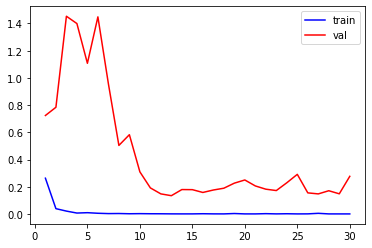

In [32]:
import matplotlib.pyplot as plt

loss = history.history['loss']
acc = history.history['acc']

val_loss = history.history['val_loss']
val_acc = history.history['val_acc']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'b', label='train')
plt.plot(epochs, val_loss, 'r', label='val')
  

plt.legend()
plt.show()

## 3.2 Accuracy

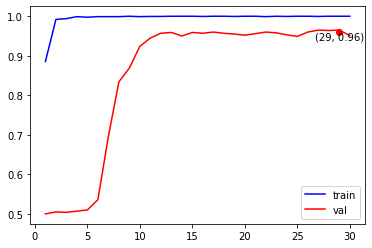

In [45]:
plt.figure()
plt.plot(epochs, acc, 'b', label='train')
plt.plot(epochs, val_acc, 'r', label='val')

max_epoch = epochs[-2]
max_val_acc = round(val_acc[-2], 2)
plt.plot(max_epoch, max_val_acc, 'ro')
plt.text(max_epoch, max_val_acc, (max_epoch, max_val_acc), ha='center', va='top', fontsize=10)

plt.legend()
plt.show()